In [7]:
import os
import asyncio
from dotenv import load_dotenv
from openai import AsyncOpenAI
import aiohttp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from typing import List, Dict


In [17]:
load_dotenv(override=True)
client = AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY"))

HEADERS = {"User-Agent": "Mozilla/5.0"}
BING_NEWS_URL = "https://www.bing.com/news/search?q={query}"


In [19]:
import openai

def check_api_key(api_key):
    try:
        openai.api_key = api_key
        openai.models.list()
        print("✅ API key is valid!")
        return True
    except Exception as e:
        print("❌ Invalid API Key:", e)
        return False

# Usage
if not check_api_key(api_key):
    raise ValueError("❌ Please check your OpenAI API key.")


❌ Invalid API Key: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-.... You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ValueError: ❌ Please check your OpenAI API key.

In [20]:
async def fetch_html(session, url):
    async with session.get(url, headers=HEADERS) as response:
        return await response.text()

async def scrape_bing_news(session, keyword: str, max_results: int = 10):
    query = keyword.replace(" ", "+")
    url = BING_NEWS_URL.format(query=query)
    html = await fetch_html(session, url)
    soup = BeautifulSoup(html, "html.parser")
    articles = soup.select("div.news-card")[:max_results]
    results = []
    for article in articles:
        title_tag = article.find("a")
        snippet_tag = article.find("div", class_="snippet")
        if title_tag:
            results.append({
                "title": title_tag.get_text(strip=True),
                "snippet": snippet_tag.get_text(strip=True) if snippet_tag else "No Snippet",
                "link": title_tag.get("href")
            })
    return results

async def summarize_with_openai(articles: List[Dict]) -> str:
    text_block = "\n\n".join([f"Title: {a['title']}\nSnippet: {a['snippet']}" for a in articles])
    messages = [
        {"role": "system", "content": "Summarize the following news articles."},
        {"role": "user", "content": text_block}
    ]
    response = await client.chat.completions.create(
        model="gpt-4",
        messages=messages
    )
    return response.choices[0].message.content

def visualize_articles(articles: List[Dict], keyword: str):
    titles = [f"{i+1}" for i in range(len(articles))]
    lengths = [len(article['title']) for article in articles]
    
    plt.figure(figsize=(10, 5))
    plt.bar(titles, lengths, color='skyblue')
    plt.xlabel('Articles')
    plt.ylabel('Title Length')
    plt.title(f'Article Title Lengths for \"{keyword}\"')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    image_path = f"{keyword}_chart.png"
    plt.savefig(image_path)
    img = Image.open(image_path)
    display(img)
    return image_path


In [21]:
class DataScraperAgent:
    async def scrape_and_visualize(self, keyword: str) -> str:
        async with aiohttp.ClientSession() as session:
            articles = await scrape_bing_news(session, keyword)
            if not articles:
                return "No articles found."
            summary = await summarize_with_openai(articles)
            visualize_articles(articles, keyword)
            return f"### Summary of Articles for '{keyword}':\n\n{summary}"


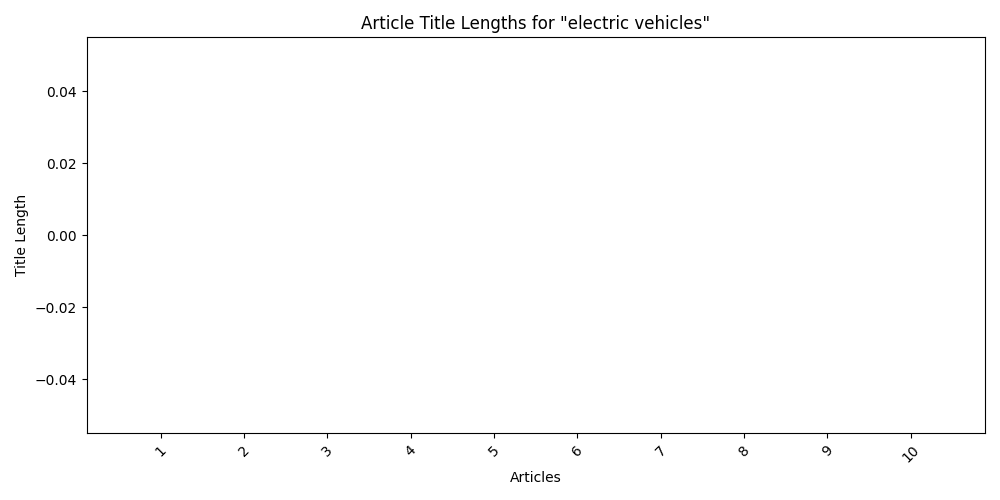

### Summary of Articles for 'electric vehicles':

1. The Chetu Foundation, a non-profit branch of the software solutions provider Chetu, introduces their charitable initiative.

2. CREST launches a new portal to promote renewable energy and science and technological advancements.

3. Indian carmaker MG Motor reports a sales increase of 158% YoY, with over 70% of revenue coming from electric vehicles.

4. Before electric vehicles became mainstream, they were a project for resourceful hobbyists.

5. BMW Manufacturing is investing in a sustainable future by focusing on electric vehicle models, celebrating their award-winning vehicles.

6. Openreach, BT Group's subsidiary, adds the 5,000th electric vehicle to its fleet, with an additional 2,000 vehicles on the way.

7. A discussion on fines and penalties for driving without a fitness certificate and operating an uninsured vehicle in India, fines range up to Rs 10,000 for repeat offenses.

8. A criticism of the Indian government's vehicle s

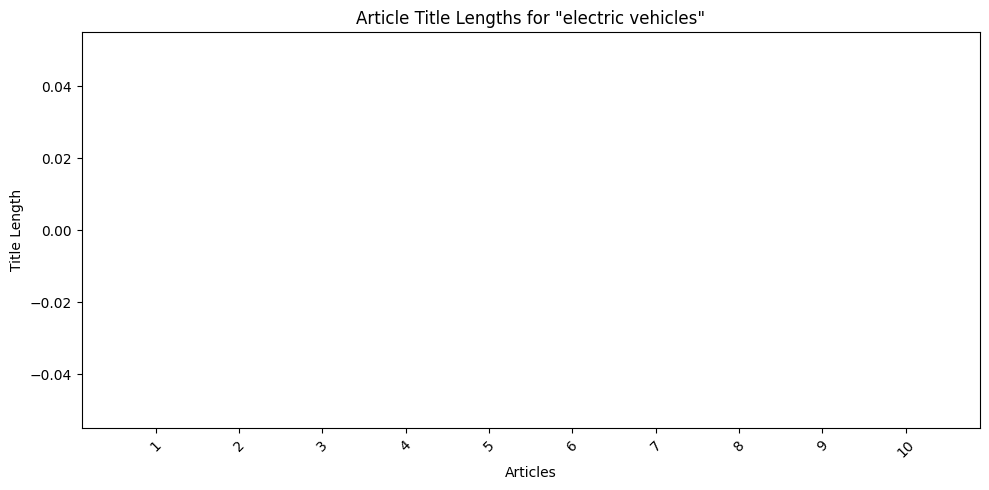

In [22]:
agent = DataScraperAgent()
async def run_agent():
    keyword = "electric vehicles"
    result = await agent.scrape_and_visualize(keyword)
    print(result)

await run_agent()
